<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project : Predicting Sales - Time Series Analysis and Forecasting
## PART 4/5: Modelling with XGBoost Regressor

--------

In [1]:
import pandas as pd
from pandas import MultiIndex, Int16Dtype
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
train = pd.read_csv("/content/drive/MyDrive/DSI30/Capstone/Kaggle/dataset/intermediate/clean_train.csv", index_col=[0], parse_dates = True)
material_master = pd.read_csv("/content/drive/MyDrive/DSI30/Capstone/Kaggle/dataset/intermediate/material_master.csv", index_col=[0])
shop_master = pd.read_csv("/content/drive/MyDrive/DSI30/Capstone/Kaggle/dataset/intermediate/shops_master.csv", index_col=[0])
test = pd.read_csv('/content/drive/MyDrive/DSI30/Capstone/Kaggle/dataset/inputs/test.csv', index_col=[0])
date_master = pd.read_csv("/content/drive/MyDrive/DSI30/Capstone/Kaggle/dataset/intermediate/date_master.csv", index_col=[0])
submission = pd.read_csv("/content/drive/MyDrive/DSI30/Capstone/Kaggle/dataset/inputs/sample_submission.csv", index_col = [0])

In [ ]:
# train = pd.read_csv("../dataset/intermediate/clean_train.csv", index_col=[0], parse_dates = True)
# material_master = pd.read_csv("../dataset/intermediate/material_master.csv", index_col=[0])
# shop_master = pd.read_csv("../dataset/intermediate/shops_master.csv", index_col=[0])
# test = pd.read_csv('../dataset/inputs/test.csv', index_col=[0])
# date_master = pd.read_csv("../dataset/intermediate/date_master.csv", index_col=[0])


In [4]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1
1,2013-01-03,0,25,2552,899.00,1
3,2013-01-06,0,25,2554,1709.05,1


In [5]:
train["date"] = pd.to_datetime(train["date"])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928485 entries, 0 to 2935842
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 156.4 MB


In [6]:
material_master.head(3)

,item_id,item_category_id,item_name_translated,item_cat_name,category,sub-category
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D,Cinema - DVD,cinema,dvd
1,2,40,*** IN THE GLORY OF THE GLORY (UNV) D,Cinema - DVD,cinema,dvd
2,3,40,*** BLUE WAVE (Univ) D,Cinema - DVD,cinema,dvd


In [7]:
shop_master.head(3)

,shop_id,shop_name_trans,city
0,0,"!Yakutsk Ordzhonikidze, 56 francs",Yakutsk
1,1,"!Yakutsk shopping center ""Central"" franc",Yakutsk
2,2,"Adygea shopping center ""Mega""",Adygea


In [8]:
test.head(3)

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233


In [9]:
date_master["date"] = pd.to_datetime(date_master["date"])
date_master.reset_index(drop = False, inplace = True)
date_master.head(3)

,date_block_num,year,month,date
0,0,2013,1,2013-01-31
1,1,2013,2,2013-02-28
2,2,2013,3,2013-03-31


## 4.1 Merge Train Set with Master Data for Clustering

In [10]:
train_i = train.merge(material_master, how="left", on = "item_id")
train_s = train_i.merge(shop_master, how = "left", on = "shop_id")
train_f = train_s.merge(date_master.iloc[:,:3], how = "left", on = "date_block_num")
train_f.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_name_translated,item_cat_name,category,sub-category,shop_name_trans,city,year,month
0,2013-01-02,0,59,22154,999.00,1,37,SCENE 2012 (BD),Cinema - Blu-Ray,cinema,blu-ray,"Yaroslavl shopping center ""Altair""",Yaroslavl,2013,1
1,2013-01-03,0,25,2552,899.00,1,58,DEEP PURPLE The House Of Blue Light LP,Music - Vinyl,music,vinyl,"Moscow TRK ""Atrium""",Moscow,2013,1
2,2013-01-06,0,25,2554,1709.05,1,58,DEEP PURPLE Who Do You Think We Are LP,Music - Vinyl,music,vinyl,"Moscow TRK ""Atrium""",Moscow,2013,1


### 4.1a Clustering of shops by Total Units Sold

In [11]:
shop_cluster = train_f.groupby(["city",
                                "shop_name_trans","year"])["item_cnt_day"].sum()
shop_cluster = shop_cluster.sort_values(ascending = False).reset_index(drop=False)
shop_cluster_year = pd.crosstab([shop_cluster["city"],shop_cluster["shop_name_trans"]], 
                                shop_cluster["year"], values = shop_cluster["item_cnt_day"],
                                aggfunc = sum).fillna(0). reset_index(drop=False)

shop_cluster_year["total"] = shop_cluster_year[2013]+shop_cluster_year[2014]+shop_cluster_year[2015]
shop_cluster_year = shop_cluster_year.sort_values(by = "total", ascending = False)
shop_cluster_year.reset_index(drop = True, inplace = True)

shop_cluster_year.loc[shop_cluster_year["total"]>100000,"cluster"] = "2" #top 8 in terms of sales
shop_cluster_year.iloc[43:,-1] = "6" # bottom 17 in terms of total sales, missing at least 1 year in sales
shop_cluster_year.iloc[8:43,-1] = "3" # mid-range in terms of total sales
shop_cluster_year.loc[shop_cluster_year["city"] == "Online", "cluster"] = "4" #Online Channels, YoY growth
shop_cluster_year.loc[shop_cluster_year["city"] == "Outbound Trade", "cluster"] = "5" #Outbound Trade
shop_cluster_year.iloc[0,-1] = "1" # Top Sales Overall
       
shop_cluster_year

year,city,shop_name_trans,2013,2014,2015,total,cluster
0,Moscow,"Moscow shopping center ""Semenovsky""",132649.0,110812.0,67769.0,311230.0,1
1,Moscow,"Moscow TRK ""Atrium""",102682.0,82840.0,56714.0,242236.0,2
2,Khimki,"Khimki Shopping Center ""Mega""",96526.0,73953.0,15669.0,186148.0,2
3,Moscow,"Moscow shopping center ""MEGA Teply Stan"" II",78764.0,65964.0,40049.0,184777.0,2
4,St. Petersburg,"St. Petersburg TC ""Nevsky Center""",53826.0,50223.0,41145.0,145194.0,2
5,Yakutsk,"Yakutsk Ordzhonikidze, 56",60285.0,52836.0,28303.0,141424.0,2
6,Moscow,"Moscow shopping center ""MEGA Belaya Dacha II""",54480.0,56028.0,26307.0,136815.0,2
7,Voronezh,"Voronezh (Plekhanovskaya, 13)",46707.0,35496.0,18554.0,100757.0,2
8,Yakutsk,"Yakutsk shopping center ""Central""",32242.0,31543.0,18123.0,81908.0,3
9,Sergiev,"Sergiev Posad shopping center ""7YA""",35907.0,27442.0,15743.0,79092.0,3


In [12]:
shop_master = shop_master.merge(shop_cluster_year.loc[:,["shop_name_trans","cluster"]],how = "left", on = "shop_name_trans")
shop_master.head(3)

,shop_id,shop_name_trans,city,cluster
0,0,"!Yakutsk Ordzhonikidze, 56 francs",Yakutsk,6
1,1,"!Yakutsk shopping center ""Central"" franc",Yakutsk,6
2,2,"Adygea shopping center ""Mega""",Adygea,3


In [13]:
shop_master["cluster"].value_counts()

3    33
6    16
2     7
4     2
5     1
1     1
Name: cluster, dtype: int64

### 4.1a Clustering of Categories by Total Units Sold

In [14]:
cat_cluster = train_f.groupby(["category","year"])["item_cnt_day"].sum().reset_index(drop=False)
cat_cluster
# cat_cluster = cat_cluster.sort_values(ascending = False).reset_index(drop=False)
cat_cluster_year = pd.crosstab(cat_cluster["category"], 
                               cat_cluster["year"], 
                               values = cat_cluster["item_cnt_day"],
                               aggfunc = sum).fillna(0). reset_index(drop=False)
cat_cluster_year["total"] = cat_cluster_year[2013] + cat_cluster_year[2014] + cat_cluster_year[2015]
cat_cluster_year = cat_cluster_year.sort_values(by = "total", ascending = False)
cat_cluster_year.reset_index(drop = True, inplace = True)

cat_cluster_year.loc[cat_cluster_year["total"]>400000,"cluster"] = "2" #top 1
cat_cluster_year.loc[cat_cluster_year["total"]>900000,"cluster"] = "1" #next 4 in terms of sales
cat_cluster_year.iloc[5:10,-1] = "3" #next 5 in terms of sales
cat_cluster_year.iloc[10:12,-1] = "4" # low in terms of sales, but active in all 3 years
cat_cluster_year.iloc[12:,-1] = "5" # low rank, not active every year
cat_cluster_year.iloc[13,-1] = "4" # batteries

cat_cluster_year

year,category,2013,2014,2015,total,cluster
0,cinema,451735.0,307345.0,159690.0,918770.0,1
1,pc games,328620.0,240805.0,120839.0,690264.0,2
2,games,254621.0,245314.0,149188.0,649123.0,2
3,gifts,200577.0,236236.0,148144.0,584957.0,2
4,music,186287.0,145061.0,80627.0,411975.0,2
5,accessories,32944.0,35193.0,17307.0,85444.0,3
6,books,28263.0,23410.0,24754.0,76427.0,3
7,programs,36344.0,24830.0,14000.0,75174.0,3
8,payment cards,13033.0,25380.0,15496.0,53909.0,3
9,game consoles,12684.0,15720.0,3910.0,32314.0,3


In [15]:
material_master = material_master.merge(cat_cluster_year.loc[:,["category","cluster"]], on = "category", how = "left")
material_master.head()

,item_id,item_category_id,item_name_translated,item_cat_name,category,sub-category,cluster
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D,Cinema - DVD,cinema,dvd,1
1,2,40,*** IN THE GLORY OF THE GLORY (UNV) D,Cinema - DVD,cinema,dvd,1
2,3,40,*** BLUE WAVE (Univ) D,Cinema - DVD,cinema,dvd,1
3,4,40,*** BOX (GLASS) D,Cinema - DVD,cinema,dvd,1
4,5,40,*** NEW AMERICAN GRAPHICS (UNI) D,Cinema - DVD,cinema,dvd,1


In [16]:
material_master["cluster"].value_counts()

2    11797
1     7464
3     2836
5       39
4       34
Name: cluster, dtype: int64

## 4.2 Transform data for input into model

### 4.2a Create lags 1-33 for each shop and item combi

In [17]:
train_mth = train.groupby(["date_block_num","shop_id","item_id"])["item_cnt_day"].sum().reset_index(drop=False)
train_mth = train_mth.merge(date_master.loc[:,["date_block_num","date"]],how = "left", on = "date_block_num")
train_mth["date"] = pd.to_datetime(train_mth["date"])
train_T = pd.crosstab(train_mth["date_block_num"],
                      [train_mth["shop_id"],train_mth["item_id"]], 
                      values = train_mth["item_cnt_day"], 
                      aggfunc = sum).fillna(0).astype(int).T.reset_index(drop=False)
train_T.head()


date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4.2b Merge with Cluster info

In [18]:
train_cat = train_T.merge(material_master.loc[:,["item_id","cluster"]],how="left", on="item_id")
train_clust = train_cat.merge(shop_master.loc[:,["shop_id","cluster"]], how="left", on="shop_id", suffixes=("_cat","_shop"))
train_clust

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,cluster_cat,cluster_shop
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424092,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
424093,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,3
424094,59,22162,0,0,0,0,0,0,0,0,...,4,1,1,0,0,1,0,0,1,3
424095,59,22164,0,0,0,0,0,0,0,0,...,1,2,0,0,1,0,0,0,1,3


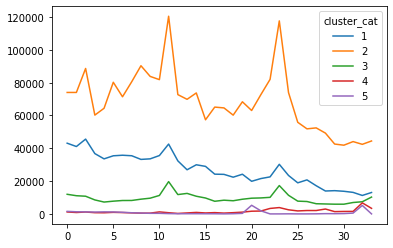

In [111]:
cluster_group = train_clust.groupby("cluster_cat")[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]].sum()
cluster_group.T.plot()

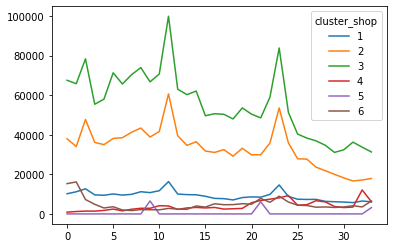

In [112]:
cluster_group_s = train_clust.groupby("cluster_shop")[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]].sum()
cluster_group_s.T.plot()

In [19]:
#dummify clusters
to_dummify = ["cluster_cat","cluster_shop"]
input_cluster = pd.get_dummies(train_clust, columns = to_dummify)
input_cluster.head()


,shop_id,item_id,0,1,2,3,4,5,6,7,...,cluster_cat_2,cluster_cat_3,cluster_cat_4,cluster_cat_5,cluster_shop_1,cluster_shop_2,cluster_shop_3,cluster_shop_4,cluster_shop_5,cluster_shop_6
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 4.2c Filter by dropping redundant dummy columns and rearrange for train-test-split

In [20]:
col_filter =  ['shop_id', 'item_id',
               'cluster_cat_1',  'cluster_cat_2',  'cluster_cat_3',  'cluster_cat_4',
               'cluster_shop_1', 'cluster_shop_2', 'cluster_shop_3', 'cluster_shop_4', 'cluster_shop_6',
               0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

#drop cluster drop 5 since the it is missing from test

In [21]:
train_input = input_cluster.loc[:,col_filter]
print(train_input.shape)
train_input.head()

(424097, 45)


,shop_id,item_id,cluster_cat_1,cluster_cat_2,cluster_cat_3,cluster_cat_4,cluster_shop_1,cluster_shop_2,cluster_shop_3,cluster_shop_4,...,24,25,26,27,28,29,30,31,32,33
0,0,30,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4.3 Transform test dataset into similar format

### 4.3a Insert cluster info, dummify

In [27]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [28]:
test_cat = test.merge(material_master.loc[:,["item_id","cluster"]],how="left", on="item_id")
test_clust = test_cat.merge(shop_master.loc[:,["shop_id","cluster"]], how="left", on="shop_id", suffixes=("_cat","_shop"))

test_dummy = pd.get_dummies(test_clust, columns = to_dummify)
test_dummy.head()

,shop_id,item_id,cluster_cat_1,cluster_cat_2,cluster_cat_3,cluster_cat_4,cluster_cat_5,cluster_shop_1,cluster_shop_2,cluster_shop_3,cluster_shop_4,cluster_shop_6
0,5,5037,0,1,0,0,0,0,0,1,0,0
1,5,5320,0,1,0,0,0,0,0,1,0,0
2,5,5233,0,1,0,0,0,0,0,1,0,0
3,5,5232,0,1,0,0,0,0,0,1,0,0
4,5,5268,0,1,0,0,0,0,0,1,0,0


In [29]:
# merge with historical data in train set
test_model = test_dummy.merge(input_cluster.iloc[:,:36],how = "left", on=["item_id","shop_id"]).fillna(0)
test_model.head(3)

,shop_id,item_id,cluster_cat_1,cluster_cat_2,cluster_cat_3,cluster_cat_4,cluster_cat_5,cluster_shop_1,cluster_shop_2,cluster_shop_3,...,24,25,26,27,28,29,30,31,32,33
0,5,5037,0,1,0,0,0,0,0,1,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0


In [30]:
test_col_filter =  ['shop_id', 'item_id',
               'cluster_cat_1',  'cluster_cat_2',  'cluster_cat_3',  'cluster_cat_4',
               'cluster_shop_1', 'cluster_shop_2', 'cluster_shop_3', 'cluster_shop_4', 'cluster_shop_6',
               1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Training will use Jan'13-Sep'15 data to predict Oct'15
# Testing will use Feb'13-Oct'15 data to predict Nov'15

In [31]:
test_input = test_model.loc[:,test_col_filter]
print(test_input.shape)
test_input = test_input.astype(int)
test_input.head()

(214200, 44)


,shop_id,item_id,cluster_cat_1,cluster_cat_2,cluster_cat_3,cluster_cat_4,cluster_shop_1,cluster_shop_2,cluster_shop_3,cluster_shop_4,...,24,25,26,27,28,29,30,31,32,33
0,5,5037,0,1,0,0,0,0,1,0,...,2,0,0,0,1,1,1,3,1,0
1,5,5320,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,5,5233,0,1,0,0,0,0,1,0,...,0,0,0,0,3,2,0,1,3,1
3,5,5232,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,5,5268,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# create dict to rename columns
date_block_num = [num for num in range(0,34)]
reversed = [n for n in range(0,34)]
reversed.reverse()
train_cols = [f"lag {x}" for x in reversed]
train_dict = {i:j for i,j in zip(date_block_num,train_cols)}
train_dict

{0: 'lag 33',
 1: 'lag 32',
 2: 'lag 31',
 3: 'lag 30',
 4: 'lag 29',
 5: 'lag 28',
 6: 'lag 27',
 7: 'lag 26',
 8: 'lag 25',
 9: 'lag 24',
 10: 'lag 23',
 11: 'lag 22',
 12: 'lag 21',
 13: 'lag 20',
 14: 'lag 19',
 15: 'lag 18',
 16: 'lag 17',
 17: 'lag 16',
 18: 'lag 15',
 19: 'lag 14',
 20: 'lag 13',
 21: 'lag 12',
 22: 'lag 11',
 23: 'lag 10',
 24: 'lag 9',
 25: 'lag 8',
 26: 'lag 7',
 27: 'lag 6',
 28: 'lag 5',
 29: 'lag 4',
 30: 'lag 3',
 31: 'lag 2',
 32: 'lag 1',
 33: 'lag 0'}

In [73]:
date_block_num_t = [num for num in range(1,34)]
reversed_t = [n for n in range(0,34)]
reversed_t
reversed_t.reverse()
test_cols = [f"lag {x}" for x in reversed_t]
test_dict = {i:j for i,j in zip(date_block_num_t,test_cols)}
test_dict

{1: 'lag 33',
 2: 'lag 32',
 3: 'lag 31',
 4: 'lag 30',
 5: 'lag 29',
 6: 'lag 28',
 7: 'lag 27',
 8: 'lag 26',
 9: 'lag 25',
 10: 'lag 24',
 11: 'lag 23',
 12: 'lag 22',
 13: 'lag 21',
 14: 'lag 20',
 15: 'lag 19',
 16: 'lag 18',
 17: 'lag 17',
 18: 'lag 16',
 19: 'lag 15',
 20: 'lag 14',
 21: 'lag 13',
 22: 'lag 12',
 23: 'lag 11',
 24: 'lag 10',
 25: 'lag 9',
 26: 'lag 8',
 27: 'lag 7',
 28: 'lag 6',
 29: 'lag 5',
 30: 'lag 4',
 31: 'lag 3',
 32: 'lag 2',
 33: 'lag 1'}

In [75]:
train_input.columns

Index([       'shop_id',        'item_id',  'cluster_cat_1',  'cluster_cat_2',
        'cluster_cat_3',  'cluster_cat_4', 'cluster_shop_1', 'cluster_shop_2',
       'cluster_shop_3', 'cluster_shop_4', 'cluster_shop_6',                0,
                      1,                2,                3,                4,
                      5,                6,                7,                8,
                      9,               10,               11,               12,
                     13,               14,               15,               16,
                     17,               18,               19,               20,
                     21,               22,               23,               24,
                     25,               26,               27,               28,
                     29,               30,               31,               32,
                     33],
      dtype='object')

In [79]:
train_input.rename(columns = train_dict, inplace = True)
test_input.rename(columns = test_dict, inplace = True)

In [80]:
train_input.columns

Index(['shop_id', 'item_id', 'cluster_cat_1', 'cluster_cat_2', 'cluster_cat_3',
       'cluster_cat_4', 'cluster_shop_1', 'cluster_shop_2', 'cluster_shop_3',
       'cluster_shop_4', 'cluster_shop_6', 'lag 33', 'lag 32', 'lag 31',
       'lag 30', 'lag 29', 'lag 28', 'lag 27', 'lag 26', 'lag 25', 'lag 24',
       'lag 23', 'lag 22', 'lag 21', 'lag 20', 'lag 19', 'lag 18', 'lag 17',
       'lag 16', 'lag 15', 'lag 14', 'lag 13', 'lag 12', 'lag 11', 'lag 10',
       'lag 9', 'lag 8', 'lag 7', 'lag 6', 'lag 5', 'lag 4', 'lag 3', 'lag 2',
       'lag 1', 'lag 0'],
      dtype='object')

In [81]:
test_input.columns

Index(['shop_id', 'item_id', 'cluster_cat_1', 'cluster_cat_2', 'cluster_cat_3',
       'cluster_cat_4', 'cluster_shop_1', 'cluster_shop_2', 'cluster_shop_3',
       'cluster_shop_4', 'cluster_shop_6', 'lag 33', 'lag 32', 'lag 31',
       'lag 30', 'lag 29', 'lag 28', 'lag 27', 'lag 26', 'lag 25', 'lag 24',
       'lag 23', 'lag 22', 'lag 21', 'lag 20', 'lag 19', 'lag 18', 'lag 17',
       'lag 16', 'lag 15', 'lag 14', 'lag 13', 'lag 12', 'lag 11', 'lag 10',
       'lag 9', 'lag 8', 'lag 7', 'lag 6', 'lag 5', 'lag 4', 'lag 3', 'lag 2',
       'lag 1'],
      dtype='object')

## 4.4 Train-test-split

In [102]:
#trim train and test sets since this has shown to improve scores in the NN models
X_train = train_input.iloc[:,2:-1].clip(0,20)
y_train = train_input.iloc[:,-1:].clip(0,20)
X_test = test_input.iloc[:,2:].clip(0,20)

X_train.shape, y_train.shape, X_test.shape

((424097, 42), (424097, 1), (214200, 42))

In [86]:
X_test.columns

Index(['cluster_cat_1', 'cluster_cat_2', 'cluster_cat_3', 'cluster_cat_4',
       'cluster_shop_1', 'cluster_shop_2', 'cluster_shop_3', 'cluster_shop_4',
       'cluster_shop_6', 'lag 33', 'lag 32', 'lag 31', 'lag 30', 'lag 29',
       'lag 28', 'lag 27', 'lag 26', 'lag 25', 'lag 24', 'lag 23', 'lag 22',
       'lag 21', 'lag 20', 'lag 19', 'lag 18', 'lag 17', 'lag 16', 'lag 15',
       'lag 14', 'lag 13', 'lag 12', 'lag 11', 'lag 10', 'lag 9', 'lag 8',
       'lag 7', 'lag 6', 'lag 5', 'lag 4', 'lag 3', 'lag 2', 'lag 1'],
      dtype='object')

In [87]:
X_train.columns

Index(['cluster_cat_1', 'cluster_cat_2', 'cluster_cat_3', 'cluster_cat_4',
       'cluster_shop_1', 'cluster_shop_2', 'cluster_shop_3', 'cluster_shop_4',
       'cluster_shop_6', 'lag 33', 'lag 32', 'lag 31', 'lag 30', 'lag 29',
       'lag 28', 'lag 27', 'lag 26', 'lag 25', 'lag 24', 'lag 23', 'lag 22',
       'lag 21', 'lag 20', 'lag 19', 'lag 18', 'lag 17', 'lag 16', 'lag 15',
       'lag 14', 'lag 13', 'lag 12', 'lag 11', 'lag 10', 'lag 9', 'lag 8',
       'lag 7', 'lag 6', 'lag 5', 'lag 4', 'lag 3', 'lag 2', 'lag 1'],
      dtype='object')

## 4.5 Modelling

In [103]:
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train,y_train)

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

In [104]:
xgb_preds = xgb_model.predict(X_test)

In [105]:
xgb_preds_df = pd.DataFrame(xgb_preds)
xgb_results = xgb_preds_df.clip(0,20)
submission_xgb = submission.merge(xgb_results, left_index = True, right_index = True, how = "left").fillna(0)
submission_xgb_f = pd.DataFrame(submission_xgb.iloc[:,-1])
submission_xgb_f.columns = ["item_cnt_month"]
submission_xgb_f["item_cnt_month"] = submission_xgb_f["item_cnt_month"].map(lambda x:int(round(x,0)))
submission_xgb_f.head()


,item_cnt_month
ID,
0,0
1,0
2,1
3,0
4,0


In [106]:
print(submission_xgb_f["item_cnt_month"].sum())
submission_xgb_f.describe()

27642


,item_cnt_month
count,214200.000000
mean,0.129048
std,0.684214
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,20.000000


In [107]:
submission_xgb_f.to_csv("/content/drive/MyDrive/DSI30/Capstone/Kaggle/dataset/outputs/kaggle_xgb_final_v2.csv")

<img src="../images/xgboost_best_score.png"
     alt="kaggle_score"
     style="float: left; margin-right: 10px;" />